In [1]:
import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
import qgrid
qgrid.nbinstall(overwrite=True)

import numpy as np
import pandas as pd

# Regression
### Thomas Schmelzer

# Linear Regression

Let $\mathbf{A} \in \mathbb{R}^{n \times m}$ and $\mathbf{b} \in \mathbb{R}^n$. Solve the unconstrained least squares problem: 

\begin{align}
\mathbf{x}^{*}=\arg\min_{\mathbf{x} \in \mathbb{R}^m}& \rVert{\mathbf{A}\mathbf{x}-\mathbf{b}}\lVert_2
\end{align}

The $i$th column of $\mathbf{A}$ may represent the time series of returns for asset $i$. 

Portfolio Optimisation is about all about clever (linear) combinations of assets. 



# Examples:
- Tracking an index (index in $\mathbf{b}$, assets in $\mathbf{A}$)
- Constructing an indicator, factor analyis, ...
- Approximation...
- ...

Regression is the **Swiss army knife** of professional quant finance. 

# The normal equations

As we (probably) all know 

$$
\mathbf{x}^{*}=\left(\mathbf{A}^T \mathbf{A}\right)^{-1}\mathbf{A}^{T}\mathbf{x}
$$
solves
\begin{align}\mathbf{x}^{*}=\arg\min_{\mathbf{x} \in \mathbb{R}^m}& \rVert{\mathbf{A}\mathbf{x}-\mathbf{b}}\lVert_2
\end{align}

You may see here already
 + The matrix $\mathbf{A}^T \mathbf{A}$ is a scaled covariance matrix (if the columns of $\mathbf{A}$ are centered). Run into problems with small eigenvalues here...
 
**Nerd alarm**: Being a numerical analyst I recommend to use the SVD or QR-decomposition to solve the unconstrained least squares problem.


# Constrained regression

Let $\mathbf{A} \in \mathbb{R}^{n \times m}$ and $\mathbf{b} \in \mathbb{R}^n$. We solve the constrained least squares problem: 

\begin{align}\mathbf{x}^{*}=\arg\min_{\mathbf{x} \in \mathbb{R}^m}& \rVert{\mathbf{A}\mathbf{x}-\mathbf{b}}\lVert_2\\
\text{s.t. } &\Sigma\,x_i=1\\
            &\mathbf{x}\geq 0
\end{align}

# The Sculptor method 
<div>
<img src="talk/thales.jpg" style="margin-left:auto; margin-right:auto; display:block">
Thales of Miletus (c. 624 BC -  c. 546 BC)
</div>

Shall we apply the sculptor method?
- We could delete the negative entries (really bad if they are all negative)
- We could scale the surviving entries to enforce the $\Sigma\,x_i=1$.

Done?

<div>
<img src="talk/cone.png" style="margin-left:auto; margin-right:auto; display:block">
$$y \geq \sqrt{x_1^2 + x_2^2}=\rVert{\mathbf{x}}\lVert_2$$
</div>

# Conic Programming

We introduce an auxiliary scalar $z$:
    
\begin{align}\min_{z \in \mathbb{R}, \mathbf{x} \in \mathbb{R}^m} & z\\
\text{s.t. }&z \geq \rVert{\mathbf{A}\mathbf{x}-\mathbf{b}}\lVert_2\\
            &\Sigma\,x_i=1\\
            &\mathbf{x}\geq 0
\end{align}


We introduce an auxiliary vector $\mathbf{y} \in \mathbb{R}^n$:

\begin{align}\min_{z \in \mathbb{R}, \mathbf{x} \in \mathbb{R}^m, \mathbf{y} \in \mathbb{R}^n} & z\\
\text{s.t. }&z \geq \rVert{y}\lVert_2\\
            &\mathbf{y} = \mathbf{A}\mathbf{x}-\mathbf{b}\\
            &\Sigma\,x_i=1\\
            &\mathbf{x}\geq 0
\end{align}

We **lifted** the problem from a $m$ dimensional space into a $m + n + 1$ dimensional space. 

**Nerd alarm**: $$z \geq \rVert{y}\lVert_2 \,\Leftrightarrow\, [z,y] \in \mathcal{Q}_{n+1}$$

# Application: Implementing a minimum variance portfolio
The $i$th column of $\mathbf{A}$ is the time series of returns for the $i$th asset.
Hence to minimize the variance of a portfolio (a linear combination of assets) we solve:

\begin{align}\mathbf{w}^{*}=\arg\min_{\mathbf{w} \in \mathbb{R}^m}& \rVert{\mathbf{A}\mathbf{w}-\mathbf{0}}\lVert_2\\
\text{s.t. } &\Sigma\,w_i=1\\
            &\mathbf{w}\geq 0
\end{align}

**Nerd alarm**: This is strictly speaking not a Minimum Variance portfolio as we use squared deviations from $0$ rather than from the mean.  

In [2]:
from cvx.util import cvx2np, minimize, cvx

def min_var(matrix, lamb=0.0):
    """
    min 2-norm (matrix*w) + lamb*2-norm(w)
    s.t. e'w = 1, w >= 0
    """
    w = cvx.Variable(matrix.shape[1])
    minimize(objective=cvx.norm(matrix*w,2)+lamb*cvx.norm(w,2), 
             constraints=[0 <= w, cvx.sum_entries(w) == 1])
    return cvx2np(w)

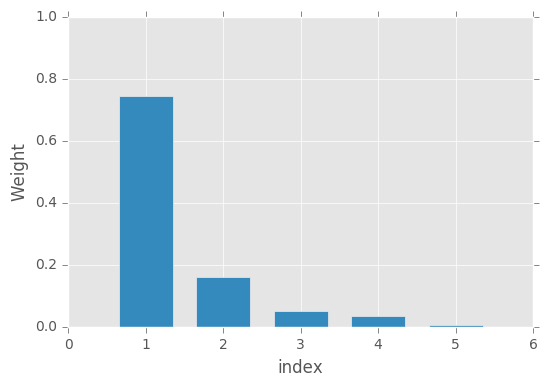

In [3]:
def plot(ax, data, width=0.35, title=""):
    ax.bar(np.arange(5)+1-width, data, 2*width)
    ax.set_ylabel("Weight"), ax.set_xlabel("index"), ax.set_title(title)
    ax.set_ylim([0,1])
    return ax
    
random_data = np.dot(np.random.randn(250,5), np.diag([1,2,3,4,5]))
data = min_var(random_data)

fig, ax = plt.subplots()
plot(ax, data)
plt.show()

# Balance?

- Bounds
- **Tikhonov regularization** (penalty by the $2$-norm of the weights in the objective), also known as **Ridge Regression** or **Shrinkage to the mean**
 

\begin{align}\mathbf{w}^{*}=\arg\min_{\mathbf{w} \in \mathbb{R}^m}& \rVert{\mathbf{A}\mathbf{w}}\lVert_2 + \lambda \rVert{\mathbf{w}}\lVert_2\\
\text{s.t. } &\Sigma\,w_i=1\\
            &\mathbf{w}\geq 0
\end{align}

- The $1/N$ portfolio is the limit for $\lambda \to \infty$


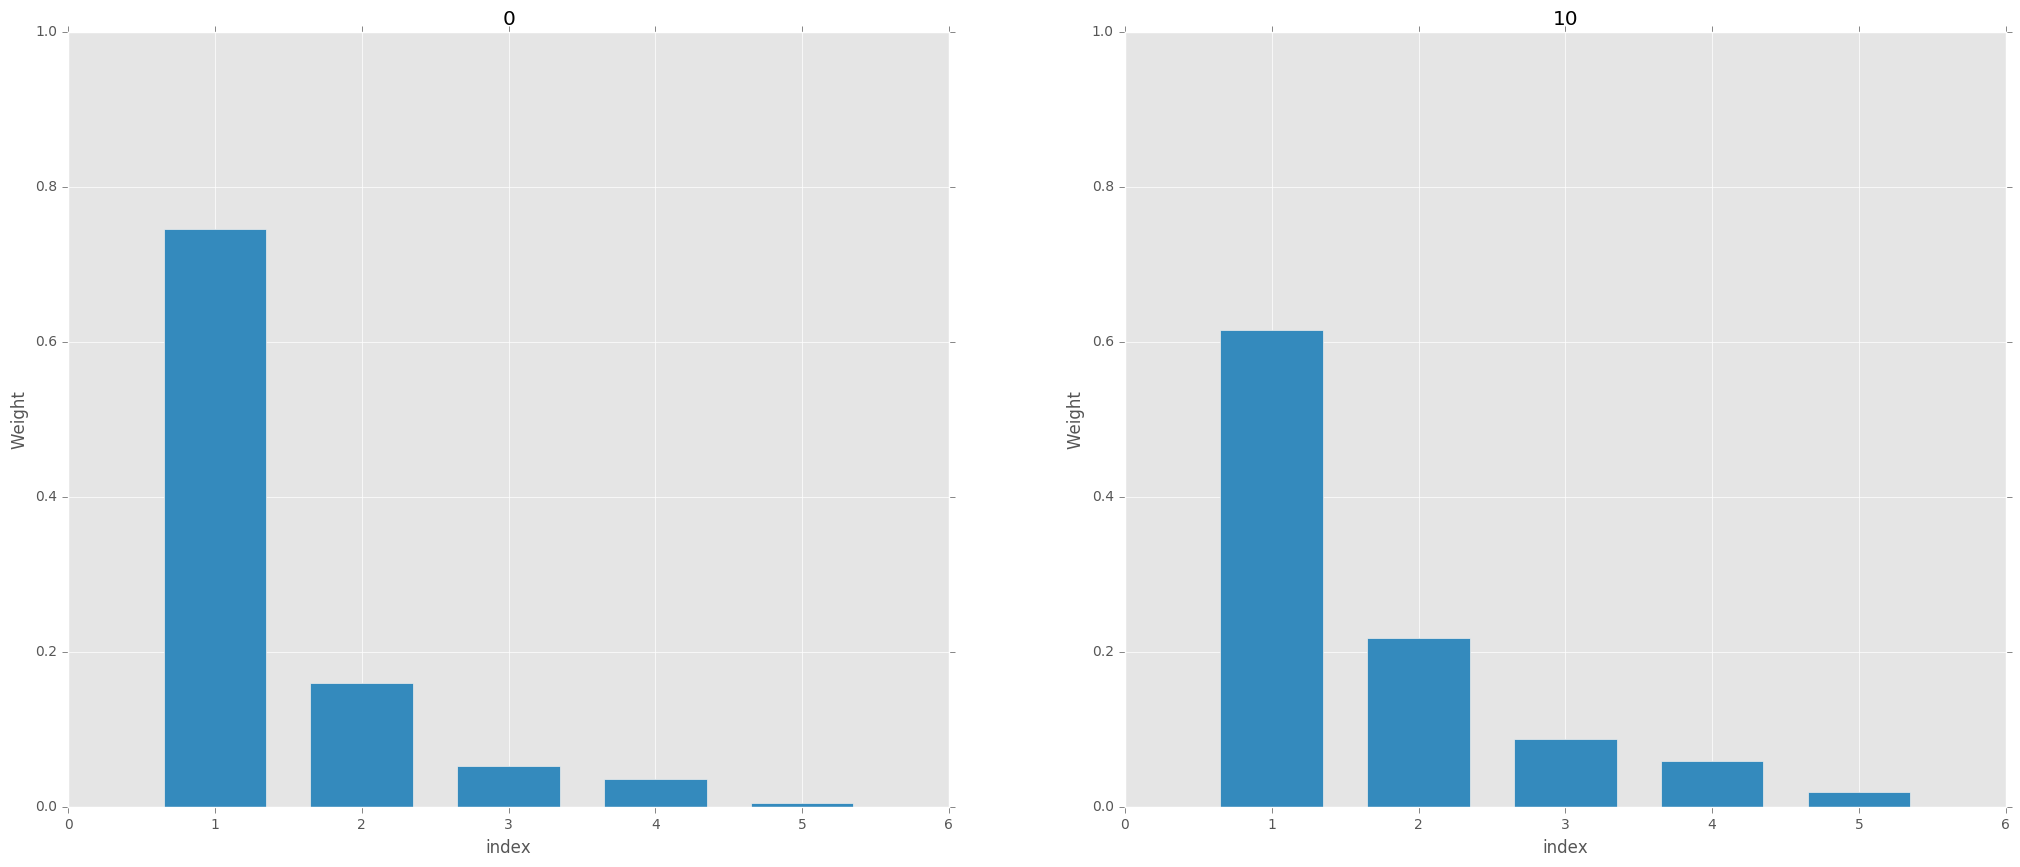

In [4]:
f, axs = plt.subplots(1,2,figsize=(25,10))
plot(axs[0], data=min_var(random_data, lamb=0), title="0")
plot(axs[1], data=min_var(random_data, lamb=10), title="10")
plt.show()

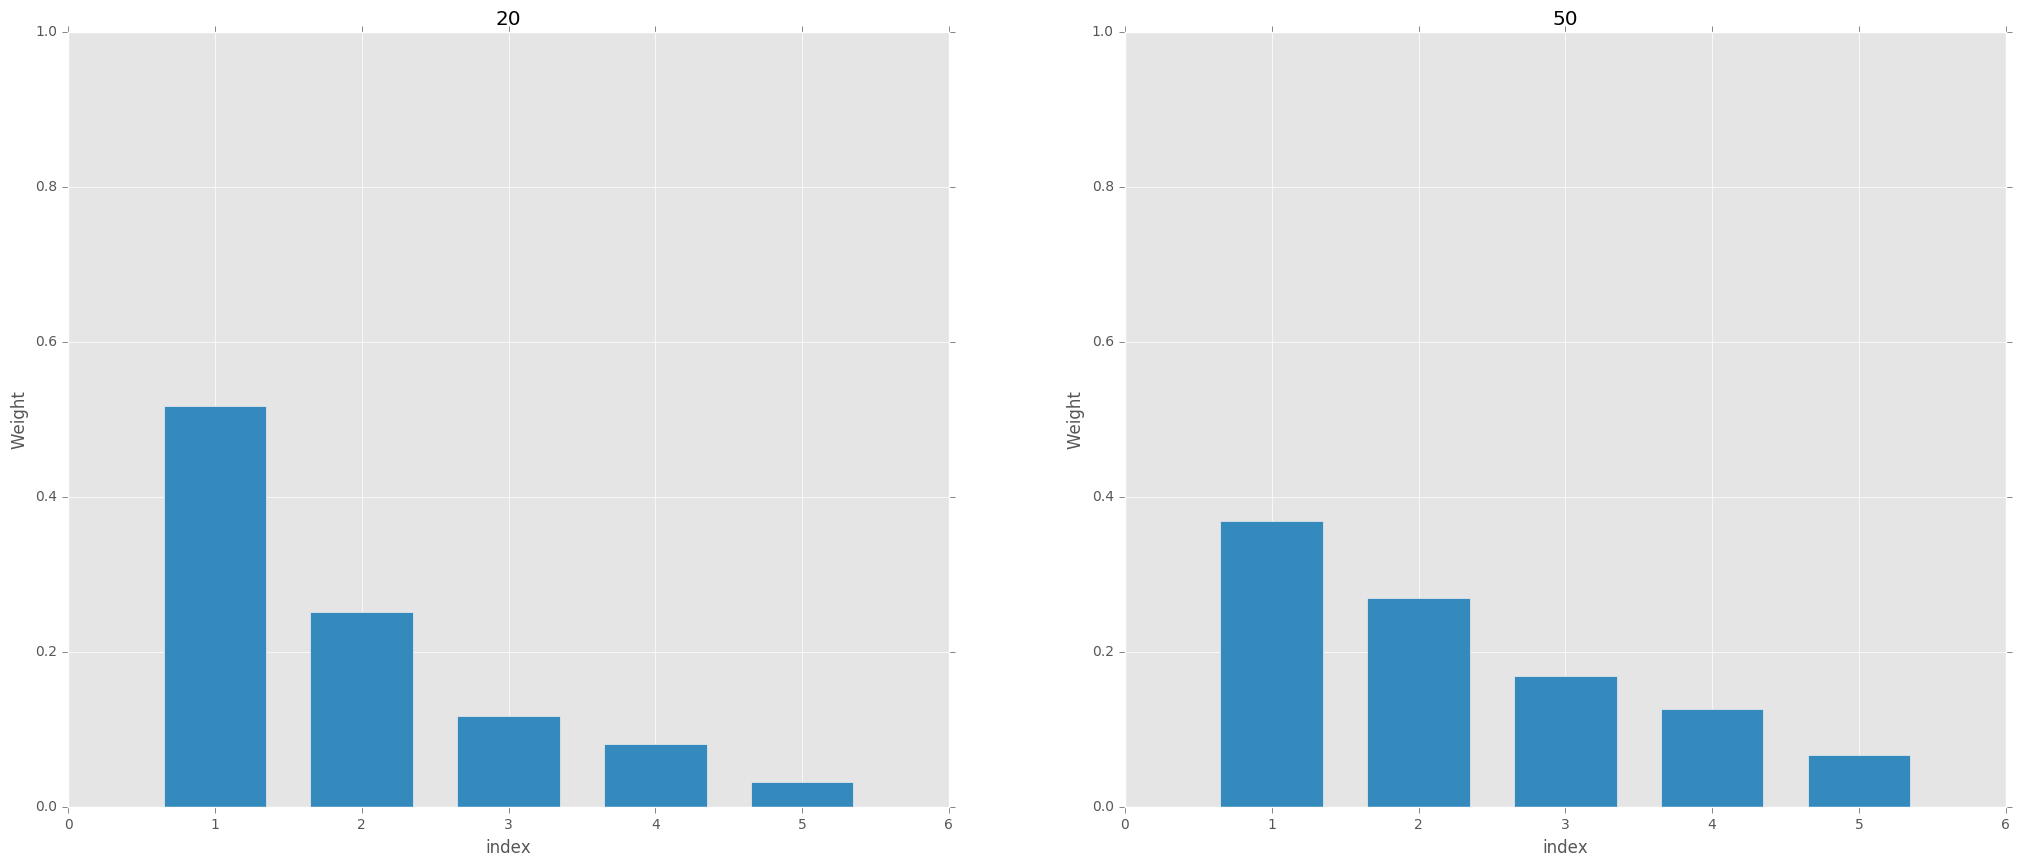

In [5]:
f, axs = plt.subplots(1,2,figsize=(25,10))
plot(axs[0], data=min_var(random_data, lamb=20), title="20")
plot(axs[1], data=min_var(random_data, lamb=50), title="50")
plt.show()

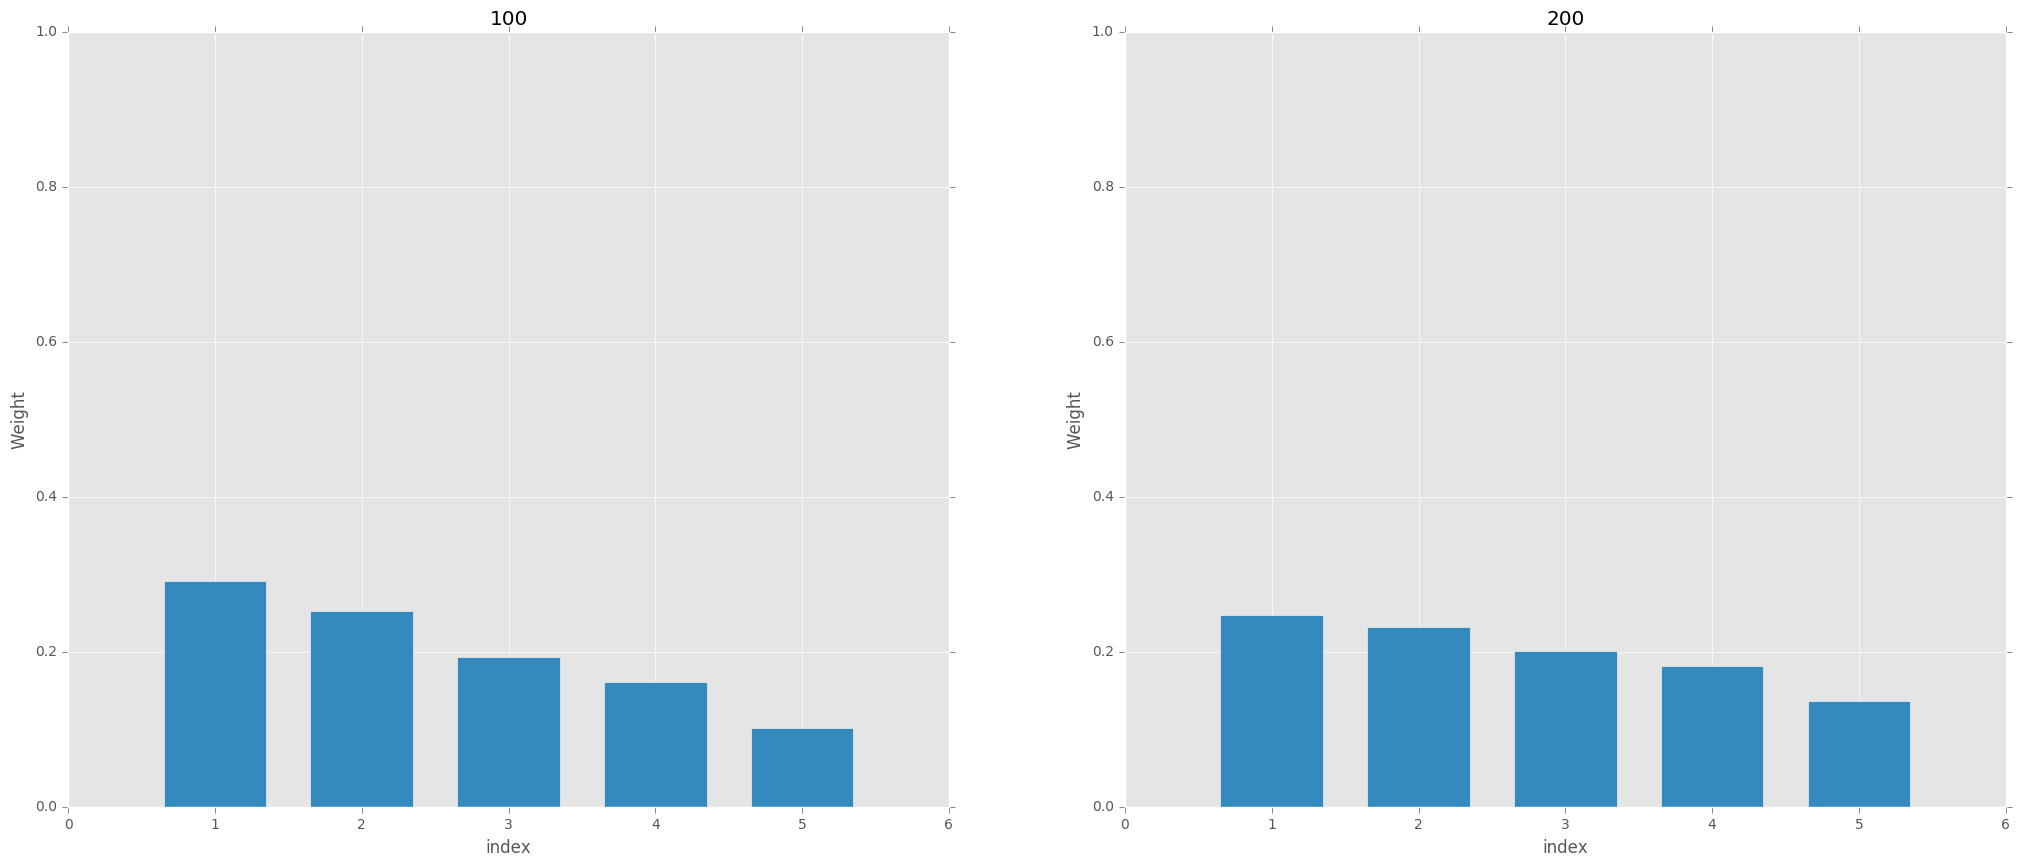

In [6]:
f, axs = plt.subplots(1,2,figsize=(25,10))
plot(axs[0], data=min_var(random_data, lamb=100), title="100")
plot(axs[1], data=min_var(random_data, lamb=200), title="200")
plt.show()

# Summary

- Although the Sculptor method (or variants thereof) are heavily used in practice such approaches are usually inefficient ways to construct feasible but not optimal solutions (have mercy upon us). 

- It's usually more effective to combine all constraints into one (conic) program. 

- Modern regularization techniques offer extreme flexibility (linear constraints on weights, level of trading activity, bounds on leverage, trading costs, ...)

- Example given: Using Tikhonov regularization we can interpolate between the Minimum Variance portfolio and the $1/N$ portfolio.

**Recommended read**: Regression techniques for Portfolio Optimisation using MOSEK, Schmelzer et al., see https://arxiv.org/abs/1310.3397
